In [ ]:
# Import Modules
import numpy as np
import pygame
import random
import math
from matplotlib import pyplot as plt

In [1]:
# Swarm Class
class swarm():
    def __init__(self, func, lowerbounds=[], upperbounds=[], number_of_particles=50, display=False,
                 migrationexists=True, pmig=0.15):
        self.lowerbounds  = lowerbounds
        self.upperbounds  = upperbounds
        self.nop          = number_of_particles
        self.display      = display
        self.func         = func
        self._vel_max     = 20.0
        self._vel_min     = -20.0
        self.member       = {}
        self.pmig         = pmig
        self.iteration_no = 0
        self.migrationexists = migrationexists
        self.__coefficients()
        
        if self.func.__name__   == 'egg':
            self.lowerbounds  = [-512,-512]
            self.upperbounds  = [512,512]
        elif self.func.__name__ == 'griewank':
            self.lowerbounds  = [-600,-600]
            self.upperbounds  = [600,600]
        
        if self.display:
            self.screen       = pygame.display.set_mode((self.upperbounds[0]-self.lowerbounds[0],
                                                         self.upperbounds[1]-self.lowerbounds[1]))
            pygame.display.set_caption("Particle Swarm Optimization")
            self.screen.fill(self.WHITE)
                    
        for ii in range(self.nop):
            self.member[str(ii)] = {'center':(0,0)}
            self.member[str(ii)]['best_value'] = 10**8
            
            self.member[str(ii)]['position']      = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['best_position'] = {str(jj): np.random.random()*\
                                                    (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                     self.lowerbounds[jj] for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['velocity']      = {str(jj): np.random.random()\
                                                     for jj in range(len(self.lowerbounds))}
            self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])),
                                              int(np.round(self.member[str(ii)]['position']['1'])))
        
        self._evaluate_fitness()
        self._distance()
    
    def __coefficients(self):
        self.BLUE  = (0,0,255)
        self.WHITE = (255,255,255)
        self.BLACK = (0,0,0)
        self.RED   = (255,0,0)
        self.__coefficients         = {}
        self.__coefficients['eta0'] = 1.0
        self.__coefficients['wght'] = 0.0196
        self.__coefficients['eta1'] = 3.9804
        self.__coefficients['eta2'] = 0.2157
        self.__coefficients['eta3'] = 3.2353
        self.__coefficients['eta4'] = 0.5098
        
    def _evaluate_fitness(self):
        '''evaluates the fitness function for the members of the swarm'''
        self.fitness_values = {'_'           :{},
                               'sorted'      :{},
                               'best'        :{},
                               'best_sorted' :{}}
        for ii in range(self.nop):
            self.member[str(ii)]['fitness_value'] = self.func([self.member[str(ii)]\
                                                    ['position'][str(jj)] for jj in\
                                                    range(len(self.lowerbounds))])
            
            if self.member[str(ii)]['fitness_value']<self.member[str(ii)]['best_value']:
                self.member[str(ii)]['best_value'] = self.member[str(ii)]['fitness_value']
                for jj in range(len(self.lowerbounds)):
                    self.member[str(ii)]['best_position'][str(jj)] = self.member[str(ii)]['position'][str(jj)]
        
            self.fitness_values['_'][str(ii)]    = self.member[str(ii)]['fitness_value']
            self.fitness_values['best'][str(ii)] = self.member[str(ii)]['best_value']

        self._sorted_fitness_value    = sorted(self.fitness_values['_'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['sorted'] = {str(self._sorted_fitness_value[ii][0]):self._sorted_fitness_value[ii][1]\
                                         for ii in range(self.nop)}
        
        self._sorted_best_value       = sorted(self.fitness_values['best'].items(), key = lambda kv:(kv[1], kv[0]))
        self.fitness_values['best_sorted'] = {str(self._sorted_best_value[ii][0]):self._sorted_best_value[ii][1]\
                                              for ii in range(self.nop)}
        
        
        self.best_position      = {list(self.fitness_values['sorted'].keys())[ii]:\
                                  self.member[list(self.fitness_values['sorted'].keys())[ii]]['position']\
                                  for ii in range(self.nop)}
        
        self.best_position_ever = {list(self.fitness_values['best_sorted'].keys())[ii]:\
                                  self.member[list(self.fitness_values['best_sorted'].keys())[ii]]['best_position']\
                                  for ii in range(self.nop)}
            
    def _distance(self):
        '''calculates the distances between the members of the swarm'''
        for ii in range(self.nop):
            self.member[str(ii)]['distance'] = {str(jj): {str(kk): self.member[str(ii)]['position'][str(kk)]-\
                                                         self.member[str(jj)]['position'][str(kk)]\
                                                         for kk in range(len(self.lowerbounds))}\
                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['distance_sorted'] = {str(jj):sorted(np.abs(self.member[str(ii)]['distance']\
                                                      [str(kk)][str(jj)]) for kk in range(self.nop)) for jj in\
                                                       range(len(self.lowerbounds))}
            
            self.member[str(ii)]['abs_distance'] = {str(jj): np.sqrt(math.fsum(self.member[str(ii)]['distance']\
                                                             [str(jj)][str(kk)]**2 for kk in\
                                                             range(len(self.lowerbounds)))) for jj in\
                                                             range(self.nop)}
            
            self.member[str(ii)]['abs_distance_sorted'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][1] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours'] = [sorted(self.member[str(ii)]['abs_distance'].items(),\
                                                          key = lambda kv:(kv[1], kv[0]))[jj][0] for jj in\
                                                          range(self.nop)]
            
            self.member[str(ii)]['closest_neighbours_fitness_values'] = {self.member[str(ii)]['closest_neighbours'][jj]:\
                                                                         self.member[self.member[str(ii)]['closest_neighbours'][jj]]['fitness_value']\
                                                                         for jj in range(self.nop)}
            
            self.member[str(ii)]['closest_neigbours_best'] = sorted(list(self.member[str(ii)]\
                                                                 ['closest_neighbours_fitness_values'].items())[1:5],
                                                                 key=lambda kv:(kv[1],kv[0]))[0][0]
            
            '''distance from the closest particle which has the best fitness value'''
            self.member[str(ii)]['distance_from_closest_best'] = self.member[str(ii)]['distance']\
                                                                [self.member[str(ii)]['closest_neigbours_best']]
            
    def _migration(self):
        '''migration calculations are generated if there exists migration'''
        if np.random.random() < self.pmig:
            self.migration = True
            self.nowp  = int(np.round(0.20*self.nop))        # number of worst particles
            self.nobp  = int(np.round(0.20*self.nop))        # number of best particles
            self.w2bp  = self._sorted_fitness_value[::-1]    # sorted worst to best particles and fitnesses
            self.b2wp  = self._sorted_fitness_value          # sorted best to worst particles and fitnesses
            self.bafv  = np.average([self._sorted_fitness_value[ii][1]\
                                    for ii in range(self.nobp)]) # best average fitness value
            self.bapos = {str(jj): np.average([self.member[self._sorted_fitness_value[ii][0]]\
                                              ['position'][str(jj)] for ii in range(self.nobp)])\
                                              for jj in range(len(self.lowerbounds))} # best average positions
            self.worst_particle_indices = {}
            counter = 0
            for ii in range(4):
                # worst particle indices are seperated 4 sub-groups from worst to best
                self.worst_particle_indices[ii] = [self.w2bp[counter+ii][0] for\
                                                   ii in range(int(np.round(0.25*self.nowp)))]
                counter = counter + int(np.round(0.25*self.nowp))
                
            for ind in (self.worst_particle_indices[0]):
                self.member[str(ind)]['position'] = {str(jj): np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              self.lowerbounds[jj] for jj in\
                                                              range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[1]):
                self.member[str(ind)]['position'] = {str(jj): 0.10*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              np.random.permutation([-1,1])[0]*self.bapos[str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[2]):
                self.member[str(ind)]['position'] = {str(jj): 0.05*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              list(self.best_position.values())[0][str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
                
            for ind in (self.worst_particle_indices[3]):
                self.member[str(ind)]['position'] = {str(jj): 0.05*np.random.random()*\
                                                              (self.upperbounds[jj]-self.lowerbounds[jj])+\
                                                              list(self.best_position_ever.values())[0][str(jj)]\
                                                              for jj in range(len(self.lowerbounds))}
                self.member[str(ind)]['velocity'] = {str(jj): np.random.random()\
                                                              for jj in range(len(self.lowerbounds))}
            
            for ii in range(4):
                for ind in (self.worst_particle_indices[ii]):
                    for jj in range(len(self.lowerbounds)):
                        if self.member[str(ind)]['position'][str(jj)] > self.upperbounds[jj]:
                            self.member[str(ind)]['position'][str(jj)] = self.upperbounds[jj]
                        elif self.member[str(ind)]['position'][str(jj)] < self.lowerbounds[jj]:
                            self.member[str(ind)]['position'][str(jj)] = self.lowerbounds[jj]
                            
        else:
            self.migration    = False
                    
    def _optimize(self):
        '''PSO algoritm'''
        for ii in range(self.nop):
            for jj in range(len(self.lowerbounds)):
                self.member[str(ii)]['velocity'][str(jj)] =  self.__coefficients['eta0'] * np.random.random()*\
                                                             ((self.__coefficients['wght'] * \
                                                             self.member[str(ii)]['velocity'][str(jj)]) + \
                                                             self.__coefficients['eta1'] * np.random.random() * \
                                                             self.member[str(ii)]['best_position'][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             self.__coefficients['eta2'] * np.random.random() * \
                                                             list(self.best_position.values())[0][str(jj)] - \
                                                             self.member[str(ii)]['position'][str(jj)] + \
                                                             self.__coefficients['eta3'] * np.random.random() * \
                                                             list(self.member[str(ii)]['distance_sorted'].values())[jj][1] + \
                                                             self.__coefficients['eta4'] * np.random.random() * \
                                                             self.member[str(ii)]['distance_from_closest_best']\
                                                             [str(jj)])
        
                if self.member[str(ii)]['velocity'][str(jj)] > self._vel_max:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_max
                elif self.member[str(ii)]['velocity'][str(jj)] < self._vel_min:
                    self.member[str(ii)]['velocity'][str(jj)] = self._vel_min
                    
                self.member[str(ii)]['position'][str(jj)] = self.member[str(ii)]['position'][str(jj)] + \
                                                            self.member[str(ii)]['velocity'][str(jj)]
                
                if self.member[str(ii)]['position'][str(jj)] > self.upperbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.upperbounds[jj]
                elif self.member[str(ii)]['position'][str(jj)] < self.lowerbounds[jj]:
                    self.member[str(ii)]['position'][str(jj)] = self.lowerbounds[jj]
             
    def update(self,iteration=50): 
        '''updates the position and velocity of the members of the swarm'''
        self.iteration = iteration
        for iter_no in range(self.iteration):
            self.iteration_no = self.iteration_no + 1
            self._optimize()
            self._evaluate_fitness()
            self._distance()
            if self.migrationexists:
                self._migration()
                if self.migration:
                    self._evaluate_fitness()
                    self._distance()

            for ii in range(self.nop):
                self.member[str(ii)]['center'] = (int(np.round(self.member[str(ii)]['position']['0'])\
                                                      -self.lowerbounds[0]),
                                                  int(np.round(self.member[str(ii)]['position']['1'])\
                                                      +self.upperbounds[0]))
                if self.display:
                    pygame.draw.circle(self.screen,self.BLUE,self.member[str(ii)]['center'],2)

            if self.display:
                pygame.display.flip()     
                self.screen.fill(self.WHITE)
                
            print('iteration no       : ',self.iteration_no)
            print('migration          : ',self.migration)
            print('best_particle      : ',list(self.best_position.keys())[0])
            print('best_position      : ',self.member[list(self.best_position.keys())[0]]['best_position'])
            print('best_value         : ',self.member[list(self.best_position.keys())[0]]['fitness_value'])
            print('best_particle_ever : ',list(self.best_position_ever.keys())[0])
            print('best_position_ever : ',self.member[list(self.best_position_ever.keys())[0]]['best_position'])
            print('best_value_ever    : ',self.member[list(self.best_position_ever.keys())[0]]['best_value'])
            print('--------------------------------------------------------')

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Universal Test Functions
def egg(*args):
    x1    = args[0][0]
    x2    = args[0][1]
    term1 = -(x2+47) * math.sin(math.sqrt(math.fabs(x2+x1/2+47)))
    term2 = -x1 * math.sin(math.sqrt(math.fabs(x1-(x2+47))))
    out   = term1 + term2
    return out

def griewank(*args):
    d    = len(args[0])
    sum  = 0
    prod = 1
    for ii in range(d):
        xi   = args[0][ii]
        sum  = sum + xi**2/4000
        prod = prod * math.cos(xi/math.sqrt(ii+1))
    out = sum - prod + 1
    return out

def bukin6(*args):
    x1 = args[0][0]
    x2 = args[0][1]    
    term1 = 100 * math.sqrt((abs(x2-0.01*x1**2)))
    term2 = 0.01 * abs(x1+10)    
    out = term1 + term2
    return out

def ackley(*args):
    d    = len(args[0])
    c    = math.pi * 2
    b    = 0.20
    a    = 20
    
    sum1 = 0
    sum2 = 0
    
    for ii in range(d):
        xi   = args[0][ii]
        sum1 = sum1 + xi**2
        sum2 = sum2 + math.cos(c*xi)
    
    term1 = -a * math.exp(-b*math.sqrt(sum1/d))
    term2 = -math.exp(sum2/d)
    
    y = term1 + term2 + a + math.exp(1)
    
    return y

def drop(*args):
    x1 = args[0][0]
    x2 = args[0][1]
    frac1 = 1+math.cos(12*math.sqrt(x1**2 + x2**2))
    frac2 = 0.5*(x1**2 + x2**2) + 2
    out = -frac1/frac2
    return out

fitness_function             = {}
fitness_function['egg']      = egg
fitness_function['griewank'] = griewank
fitness_function['bukin6']   = bukin6
fitness_function['ackley']   = ackley
fitness_function['drop']     = drop

In [6]:
# Generate Particles
particles = swarm(func=fitness_function['egg'],number_of_particles=100,display=True)

In [7]:
# Iterate Optimization
particles.update(iteration=50)

iteration no       :  1
migration          :  False
best_particle      :  31
best_position      :  {'0': 497.17760063368087, '1': 386.3787463764516}
best_value         :  -853.1038768837428
best_particle_ever :  31
best_position_ever :  {'0': 497.17760063368087, '1': 386.3787463764516}
best_value_ever    :  -853.1038768837428
--------------------------------------------------------
iteration no       :  2
migration          :  True
best_particle      :  47
best_position      :  {'0': 512, '1': 397.7286089344578}
best_value         :  -914.1080262039084
best_particle_ever :  47
best_position_ever :  {'0': 512, '1': 397.7286089344578}
best_value_ever    :  -914.1080262039084
--------------------------------------------------------
iteration no       :  3
migration          :  True
best_particle      :  92
best_position      :  {'0': 512, '1': 403.0462434737465}
best_value         :  -958.0559630488845
best_particle_ever :  92
best_position_ever :  {'0': 512, '1': 403.0462434737465}
best_

iteration no       :  24
migration          :  True
best_particle      :  43
best_position      :  {'0': 512, '1': 405.6806352921873}
best_value         :  -957.2326105614358
best_particle_ever :  88
best_position_ever :  {'0': 512, '1': 404.31013513885637}
best_value_ever    :  -959.6336839680579
--------------------------------------------------------
iteration no       :  25
migration          :  False
best_particle      :  94
best_position      :  {'0': 512, '1': 405.2960685084618}
best_value         :  -958.3442750669362
best_particle_ever :  88
best_position_ever :  {'0': 512, '1': 404.31013513885637}
best_value_ever    :  -959.6336839680579
--------------------------------------------------------
iteration no       :  26
migration          :  True
best_particle      :  65
best_position      :  {'0': 512, '1': 405.3073887021688}
best_value         :  -958.3164591237341
best_particle_ever :  88
best_position_ever :  {'0': 512, '1': 404.31013513885637}
best_value_ever    :  -959.63

iteration no       :  47
migration          :  False
best_particle      :  83
best_position      :  {'0': 436.3759385623925, '1': 452.0}
best_value         :  -933.1303468919909
best_particle_ever :  88
best_position_ever :  {'0': 512, '1': 404.31013513885637}
best_value_ever    :  -959.6336839680579
--------------------------------------------------------
iteration no       :  48
migration          :  False
best_particle      :  51
best_position      :  {'0': 512, '1': 403.5399324639234}
best_value         :  -945.8863781834
best_particle_ever :  88
best_position_ever :  {'0': 512, '1': 404.31013513885637}
best_value_ever    :  -959.6336839680579
--------------------------------------------------------
iteration no       :  49
migration          :  False
best_particle      :  10
best_position      :  {'0': 479.19146032697324, '1': 435.069697329278}
best_value         :  -951.298066058801
best_particle_ever :  88
best_position_ever :  {'0': 512, '1': 404.31013513885637}
best_value_ever

In [8]:
# Best Positions Ever
particles.best_position_ever

{'88': {'0': 512, '1': 404.31013513885637},
 '94': {'0': 512, '1': 404.447197925942},
 '56': {'0': 512, '1': 403.9571641711461},
 '76': {'0': 512, '1': 403.918282255125},
 '6': {'0': 512, '1': 404.6552684839403},
 '62': {'0': 512, '1': 404.7827965916665},
 '54': {'0': 512, '1': 403.6341561126257},
 '23': {'0': 512.0, '1': 403.5737274528277},
 '51': {'0': 512, '1': 403.5399324639234},
 '72': {'0': 512, '1': 405.2519087517638},
 '59': {'0': 512.0, '1': 403.16584874890947},
 '65': {'0': 512, '1': 405.3073887021688},
 '92': {'0': 512, '1': 403.0462434737465},
 '43': {'0': 512, '1': 405.6806352921873},
 '40': {'0': 512, '1': 406.007876405452},
 '3': {'0': 512, '1': 406.1828969538673},
 '20': {'0': 512, '1': 406.35674575330046},
 '37': {'0': 512.0, '1': 402.07203460236946},
 '36': {'0': 511.05683575966293, '1': 401.8219439784563},
 '47': {'0': 512, '1': 401.7885069653474},
 '27': {'0': 512, '1': 406.7136141569788},
 '10': {'0': 479.19146032697324, '1': 435.069697329278},
 '80': {'0': 512, '1

In [9]:
# Best Values Ever
particles.fitness_values['best_sorted']

{'88': -959.6336839680579,
 '94': -959.5878455254622,
 '56': -959.555072828603,
 '76': -959.5291523849171,
 '6': -959.4362393848053,
 '62': -959.2942910154467,
 '54': -959.2362579537347,
 '23': -959.1505518714835,
 '51': -959.0990496338704,
 '72': -958.4499453036245,
 '59': -958.3584637407333,
 '65': -958.3164591237341,
 '92': -958.0559630488845,
 '43': -957.2326105614358,
 '40': -956.0151563227378,
 '3': -955.2611158434249,
 '20': -954.4409100704523,
 '37': -954.4201554785827,
 '36': -953.5494042596367,
 '47': -952.9744681399279,
 '27': -952.5341883742942,
 '10': -951.298066058801,
 '80': -948.5472449272236,
 '95': -946.5138588951129,
 '2': -945.9412970556751,
 '57': -943.5191716773071,
 '9': -939.8372251248875,
 '98': -939.5949105717873,
 '58': -935.2527844363226,
 '5': -934.5522990054012,
 '29': -933.4941116323284,
 '96': -933.3006588084488,
 '83': -933.1303468919909,
 '33': -932.4818705648727,
 '93': -928.6871532737281,
 '60': -925.1446155926396,
 '24': -925.0788859901859,
 '21': -

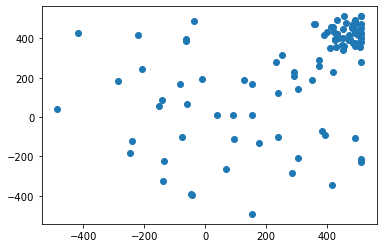

In [10]:
# Scatter Plot of the Final Positions
plt.scatter([list(particles.best_position.values())[ii]['0'] for ii in range(particles.nop)],
            [list(particles.best_position.values())[ii]['1'] for ii in range(particles.nop)])

In [11]:
# Details about the Best Particle Ever
particles.member[list(particles.best_position_ever.keys())[0]]

{'center': (1024, 984),
 'best_value': -959.6336839680579,
 'position': {'0': 512, '1': 472.0},
 'best_position': {'0': 512, '1': 404.31013513885637},
 'velocity': {'0': 20.0, '1': 20.0},
 'fitness_value': -462.54816360055213,
 'distance': {'0': {'0': 359.1706128378911, '1': 964.0},
  '1': {'0': 573.6616454347235, '1': 73.63053306236998},
  '2': {'0': 0, '1': 191.64435570650403},
  '3': {'0': 27.805813761321588, '1': 0.0},
  '4': {'0': 20.0, '1': -2.5483371994541244},
  '5': {'0': 358.89958606652476, '1': 303.9287589358553},
  '6': {'0': 20.0, '1': 110.2638833945943},
  '7': {'0': 89.25441395269166, '1': 40.73621563005548},
  '8': {'0': 151.21932075939628, '1': 0.0},
  '9': {'0': 49.12056190094182, '1': -4.944218820594585},
  '10': {'0': 32.04731042147182, '1': 16.93030267072203},
  '11': {'0': 0, '1': -40.0},
  '12': {'0': 140.30938682301763, '1': 179.76521743607225},
  '13': {'0': 416.76077609858805, '1': 583.7183167535168},
  '14': {'0': 574.5517694046986, '1': 87.44910087772564},
 